# CycleGAN
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import os
from PIL import Image
import itertools

In [2]:
import sys
sys.path.insert(1, '../src')
from helpers import save_samples, checkpoint

In [3]:
import torch
from torch import optim, nn
from torchvision import transforms, datasets
import torch.nn.functional as F

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Load and Visualize the Data

In [5]:
def get_dataloader(image_type, image_path='../../data/summer2winter_yosemite',
                   image_size=128, batch_size=16):
    '''
    Create and return train and test dataloaders
    '''
    transform = transforms.Compose(
        [transforms.Resize(int(image_size*1.12), Image.BICUBIC),
         transforms.RandomCrop(image_size),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    # path to the train and test images
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, f'test_{image_type}')
    
    train_dataset = datasets.ImageFolder(train_path, transform=transform)
    test_dataset = datasets.ImageFolder(test_path, transform=transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader

In [6]:
image_size = 128

In [7]:
train_X, test_X = get_dataloader('summer', image_size=image_size)
train_Y, test_Y = get_dataloader('winter', image_size=image_size)

#### Display some images

In [8]:
X_iter, Y_iter = iter(train_X), iter(train_Y)

images_X, _ = next(X_iter)
images_Y, _ = next(Y_iter)
images_X, images_Y = images_X.numpy(), images_Y.numpy()

In [9]:
def show_images(images):
    fig = plt.figure(figsize=(25, 8))

    for i in np.arange(10):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        img = images[i]
        img = img.transpose(1, 2, 0)
        img = 0.5 * (img + 1)
        ax.imshow(img)

**show summer images**

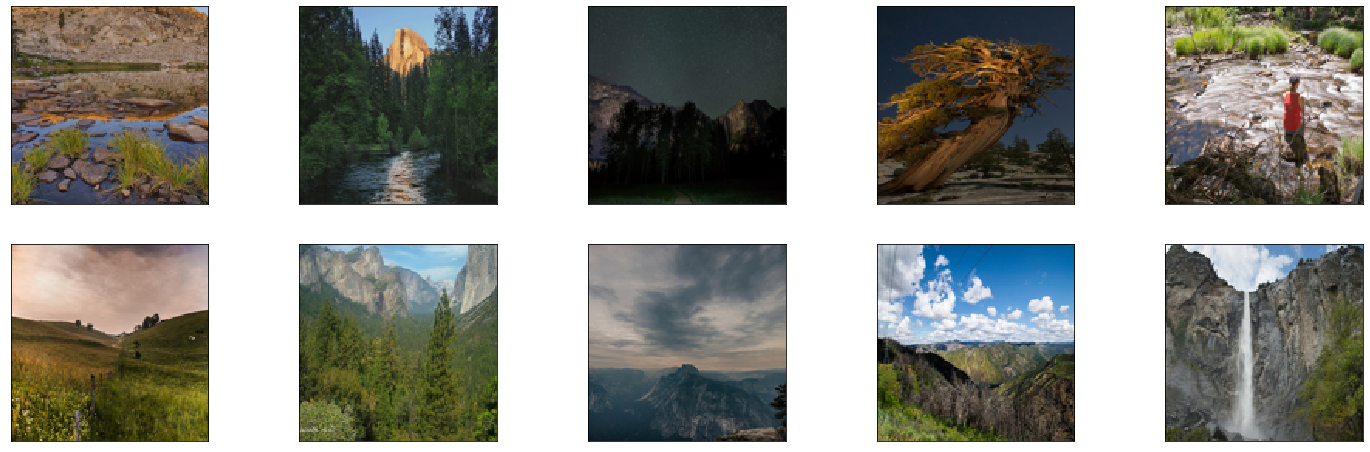

In [10]:
show_images(images_X)

**show winter images**

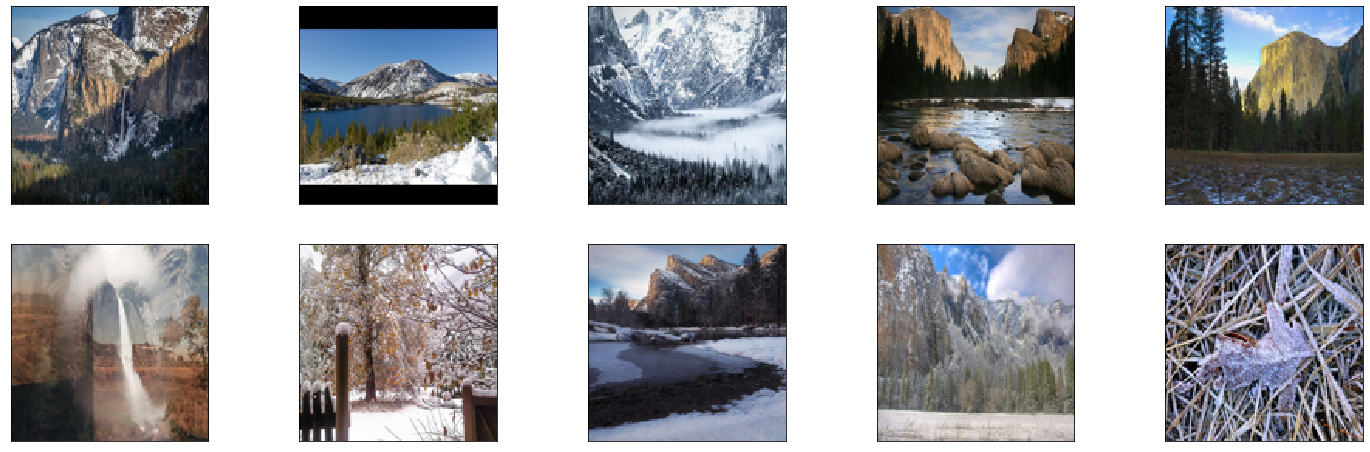

In [11]:
show_images(images_Y)

### Scaling images to required range

In [12]:
def scale_img(img, range=(-1, 1)):
    max, min = range
    return img * (max - min) + min

## Define the model

*Helper function for creating convolutional layers*

In [13]:
def conv(in_channels, out_channels, kernel_size, stride=1,
         padding=0, instance_norm=True):
    '''
    Creates a convolutional layer, followed by an optional batch normalization layer
    '''
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                           padding, bias=False)
    layers.append(conv_layer)
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    
    return nn.Sequential(*layers)

Helper function for creating fractionally strided convolution layers

In [14]:
def frac_conv(in_channels, out_channels, kernel_size, stride=2,
              padding=1, output_padding=1, instance_norm=True):
    '''
    Creates a fractionally strided convolutional layer, followed by an optional 
    instance normalization layer
    '''
    layers = []
    frac_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                         stride, padding, bias=False)
    layers.append(frac_conv_layer)
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
        
    return nn.Sequential(*layers)

### Generator

**Residual Block**

In [15]:
class ResBlock(nn.Module):
    '''
    Defines a residual network layer
    '''
    def __init__(self, n_channels):
        super().__init__()
        
        # reflection padding is used instead of zero padding
#         layers = [    nn.ReflectionPad2d(1),
#                       nn.Conv2d(n_channels, n_channels, 3),
#                       nn.InstanceNorm2d(n_channels),
#                       nn.ReLU(inplace=True),
#                       nn.ReflectionPad2d(1),
#                       nn.Conv2d(n_channels, n_channels, 3),
#                       nn.InstanceNorm2d(n_channels)   ]
#         self.model = nn.Sequential(*layers)

        self.ref_pad1 = nn.ReflectionPad2d(1)
        self.conv1 = conv(n_channels, n_channels, kernel_size=3, 
                                stride=1, padding=0)
        self.instance_norm1 = nn.InstanceNorm2d(n_channels)
        self.ref_pad2 = nn.ReflectionPad2d(1)
        self.conv2 = conv(n_channels, n_channels, kernel_size=3, 
                                stride=1, padding=0)
        self.instance_norm2 = nn.InstanceNorm2d(n_channels)
    
    def forward(self, x):
        print('before: ', x.size())
        out = self.ref_pad1(x)
        print('Ref pad 1: ', out.size())
        out = self.conv1(out)
        print('conv 1: ', out.size())
        out = self.instance_norm1(out)
        out = torch.relu(out)
        out = self.ref_pad2(x)
        print('Ref pad 2: ', out.size())
        out = self.conv2(out)
        print('conv 2 : ', out.size())
        out = self.instance_norm1(out)
        #out = self.model(x)
        return x + out

In [16]:
class Generator(nn.Module):
    '''
    Defines the generator of a cycleGAN
    '''
    def __init__(self, n_res_blocks=6):
        super().__init__()
        
        model = []
        # initial convolutional block
        model += [nn.ReflectionPad2d(3),
                  conv(3, 64, kernel_size=7, stride=1, padding=0),
                  nn.ReLU(inplace=True)]
        
        # downsampling
        # add two conv layers to downsample the input image
        model += [conv(64, 128, kernel_size=3, stride=2, padding=1),
                  nn.ReLU(inplace=True)]
        model += [conv(128, 256, kernel_size=3, stride=2, padding=1),
                  nn.ReLU(inplace=True)]
        
        # residual blocks
        model += [ResBlock(256) for i in range(n_res_blocks)]

        # upsampling
        # add two upsampling layers to upsample to original size
        model += [frac_conv(256, 128, kernel_size=3, stride=2, padding=1, 
                            output_padding=1), 
                  nn.ReLU(inplace=True)]
        model += [frac_conv(128, 64, kernel_size=3, stride=2, padding=1, 
                            output_padding=1),
                  nn.ReLU(inplace=True)]
        
        # output layer
        model += [nn.ReflectionPad2d(3),
                  conv(64, 3, kernel_size=7, stride=1, padding=0),
                  nn.Tanh()]
        
        self.model = nn.Sequential(*model)
        
    def forward(self, x):        
        return self.model(x)

## Discriminator

In [17]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        model = []
        # first conv layer does not use instance norm
        model += [conv(3, 64, kernel_size=4, stride=2, padding=1, instance_norm=False),
                  nn.LeakyReLU(0.2, inplace=True)]
        # second conv layer
        model += [conv(64, 128, kernel_size=4, stride=2, padding=1),
                  nn.LeakyReLU(0.2, inplace=True)]
        # third conv layer
        model += [conv(128, 256, kernel_size=4, stride=2, padding=1),
                  nn.LeakyReLU(0.2, inplace=True)]
        # fourth conv layer
        model += [conv(256, 512, kernel_size=4, stride=1, padding=1),
                  nn.LeakyReLU(0.2, inplace=True)]
        # FCN classifiaction layer
        model += [conv(512, 1, kernel_size=4, stride=1, padding=1)]
        
        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        out = self.model(x)
        # average pooling and flatenning
        out = F.avg_pool2d(out, out.size()[2:]).view(x.size()[0], -1)
        print(out.size())
        return out

## Weight initialization

In [18]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant(m.bias.data, 0.0)

## Loss functions

In [19]:
def real_loss(logits, scale=True):
    criterion = nn.MSELoss()
    
    labels = torch.ones_like(logits) * 0.9 if scale else torch.ones_like(logits)
    loss = criterion(logits, labels)
    return loss

In [20]:
def fake_loss(logits):
    criterion = nn.MSELoss()
    
    labels = torch.zeros_like(logits)
    loss = criterion(logits, labels)
    return loss

In [21]:
def cycle_loss(reconstructed_image, real_image):
    criterion = nn.L1Loss()
    weight = 10
    loss = weight * criterion(reconstructed_image, real_image)
    return loss

In [22]:
def identity_loss(reconstructed_image, real_image):
    '''
    Identity loss is used to regularize the generator to be near 
    an identity mapping when real samples of the target domain 
    are provided as the input to the generator:
    '''
    criterion = nn.L1Loss()
    weight = 0.5 * 10 # ie. 0.5 * lambda
    loss = weight * criterion(reconstructed_image, real_image)
    return loss

## Create the complete network

In [23]:
# generators
G_XtoY = Generator()
G_YtoX = Generator()
# discriminators
D_X = Discriminator()
D_Y = Discriminator()

G_XtoY, G_YtoX = G_XtoY.to(device), G_YtoX.to(device)
D_X, D_Y = D_X.to(device), D_Y.to(device)

# initialize the weights of the network
G_XtoY.apply(init_weights)
G_YtoX.apply(init_weights)
D_X.apply(init_weights)
D_Y.apply(init_weights);

## Define Optimizers

In [24]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

In [25]:
g_optimizer = optim.Adam(itertools.chain(G_XtoY.parameters(), G_YtoX.parameters()),
                         lr=lr, betas=(beta1, beta2))

dX_optimizer = optim.Adam(D_X.parameters(), lr=lr, betas=(beta1, beta2))
dY_optimizer = optim.Adam(D_Y.parameters(), lr=lr, betas=(beta1, beta2))

## Training the model

In [26]:
n_epochs = 100

In [27]:
print_every = 5
sample_every = 10

generator_losses = []
discriminatorX_losses = []
discriminatorY_losses = []

test_iter_X, test_iter_Y = iter(test_X), iter(test_Y)
# fixed x and y images for evaluating the model
fixed_X = scale_img(test_iter_X.next()[0])
fixed_Y = scale_img(test_iter_Y.next()[0])

iter_X, iter_Y = iter(train_X), iter(train_Y)
batches_per_epoch = min(len(iter_X), len(iter_Y))

for epoch in range(1, n_epochs+1):
    if epoch % batches_per_epoch == 0:
        # reset the iterators
        iter_X, iter_Y = iter(train_X), iter(train_Y)
        
    real_X = scale_img(iter_X.next()[0])
    real_Y = scale_img(iter_Y.next()[0])
    
    # move to gpu if available
    real_X, real_Y = real_X.to(device), real_Y.to(device)
    
    ####################################################################
    ##############            Train the generators          ############
    ####################################################################
    g_optimizer.zero_grad()
    
    # identity loss
    # G_XtoY(real_Y) should be the same as real_Y and vice versa
#     generated_Y = G_XtoY(real_Y)
#     generated_X = G_YtoX(real_X)
    
#     identity_loss_Y = identity_loss(generated_Y, real_Y)
#     identity_loss_X = identity_loss(generated_X, real_X)
    
    # GAN loss
    fake_Y = G_XtoY(real_X)
    fake_logits = D_Y(fake_Y)
    fake_loss_XtoY = real_loss(fake_logits, scale=True)
    
    fake_X = G_YtoX(real_Y)
    fake_logits = D_X(fake_X)
    fake_loss_YtoX = real_loss(fake_logits, scale=True)
    
    # Cycle loss
    reconstructed_X = G_YtoX(fake_Y)
    forward_cycle_loss = cycle_loss(reconstructed_X, real_X)
    reconstructed_Y = G_XtoY(fake_X)
    backward_cycle_loss = cycle_loss(reconstructed_Y, real_Y)
    
    # Total generator loss
#     g_loss = identity_loss_X + identity_loss_Y + fake_loss_XtoY + \
#            fake_loss_YtoX + forward_cycle_loss + backward_cycle_loss
    
    g_loss = fake_loss_XtoY + fake_loss_YtoX + forward_cycle_loss + backward_cycle_loss
    
    # backpropagate and update the weights
    g_loss.backward()
    g_optimizer.step()
    
    
    ####################################################################
    ##################      Train the Discriminators     ###############
    ####################################################################
    dX_optimizer.zero_grad()
    dY_optimizer.zero_grad()
    
    # Discriminator X
    real_logits = D_X(real_X)
    real_loss_X = real_loss(real_logits, scale=True)
    
    fake_logits = D_X(fake_X)
    fake_loss_X = fake_loss(fake_logits)
    
    total_loss_X = real_loss_X + fake_loss_X
    total_loss_X.backward()
    dX_optimizer.step()
    
    # Discriminator Y
    real_logits = D_Y(real_Y)
    real_loss_Y = real_loss(real_logits, scale=True)
    
    fake_logits = D_Y(fake_Y)
    fake_loss_Y = fake_loss(fake_logits)
    
    total_loss_Y = real_loss_Y + fake_loss_Y
    total_loss_Y.backward()
    dY_optimizer.step()
    
    ####################################################################
    ########################           Logging      ####################
    ####################################################################
    if epoch % print_every == 0:
        generator_losses.append(g_loss.item())
        discriminatorX_losses.append(total_loss_X.item())
        discriminatorY_losses.append(total_loss_Y.item())
        
        print(f'Epoch {epoch/n_epochs}  |  d_X_loss: {total_loss_X:.4f}  |  '
              f'd_Y_loss: {total_loss_Y:.4f}  |  g_loss: {g_loss:.4f}')
        
    if epoch % sample_every == 0:
        G_XtoY.eval()
        G_YtoX.eva()
        save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY)
        G_XtoY.train()
        G_YtoX.train()
        
#     checkpoint_every = 100
#     # save model parameters
#     if epoch % checkpoint_every == 0:
#         checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

before:  torch.Size([16, 256, 32, 32])
Ref pad 1:  torch.Size([16, 256, 34, 34])
conv 1:  torch.Size([16, 256, 32, 32])
Ref pad 2:  torch.Size([16, 256, 34, 34])
conv 2 :  torch.Size([16, 256, 32, 32])
before:  torch.Size([16, 256, 32, 32])
Ref pad 1:  torch.Size([16, 256, 34, 34])
conv 1:  torch.Size([16, 256, 32, 32])
Ref pad 2:  torch.Size([16, 256, 34, 34])
conv 2 :  torch.Size([16, 256, 32, 32])
before:  torch.Size([16, 256, 32, 32])
Ref pad 1:  torch.Size([16, 256, 34, 34])
conv 1:  torch.Size([16, 256, 32, 32])
Ref pad 2:  torch.Size([16, 256, 34, 34])
conv 2 :  torch.Size([16, 256, 32, 32])
before:  torch.Size([16, 256, 32, 32])
Ref pad 1:  torch.Size([16, 256, 34, 34])
conv 1:  torch.Size([16, 256, 32, 32])
Ref pad 2:  torch.Size([16, 256, 34, 34])
conv 2 :  torch.Size([16, 256, 32, 32])
before:  torch.Size([16, 256, 32, 32])
Ref pad 1:  torch.Size([16, 256, 34, 34])
conv 1:  torch.Size([16, 256, 32, 32])
Ref pad 2:  torch.Size([16, 256, 34, 34])
conv 2 :  torch.Size([16, 256,

RuntimeError: The size of tensor a (125) must match the size of tensor b (128) at non-singleton dimension 3